In [1]:
%%html
<iframe src="https://icarus.fnal.gov/" width="1200" height="1000"></iframe>

In [3]:
%%html
<marquee style='width: 55%; color: purple;'><b>RANDOM FOREST</b></marquee>

In [ ]:
 #only in colab:

from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#sigdir = /content/drive/MyDrive/nu
#backdir = /content/drive/MyDrive/cosmic

In [ ]:
sigdir = '/content/drive/MyDrive/nu'
backdir = '/content/drive/MyDrive/cosmic'

In [ ]:
print('Insert path directoty of \033[91m\033[1mSignal files\033[0m')
#sigdir = input('')
print('Insert path directoty of \033[91m\033[1mBackground files\033[0m')
#backdir = input('')
#print('\033[1m\033[94mtpc selection:\033[0m')
#tpc = int(input())
#print('\033[1m\033[94mplane selection:\033[0m')
#plane = int(input())

# Extracting  the raw data
The raw data(in contex of ICT) is provided as .root file. Hence, to extract this data type to python enviroment, we used Uproot library. Uproot ver. 3.9 is very efficient for our purposes as it could be convert to pandas data frame.

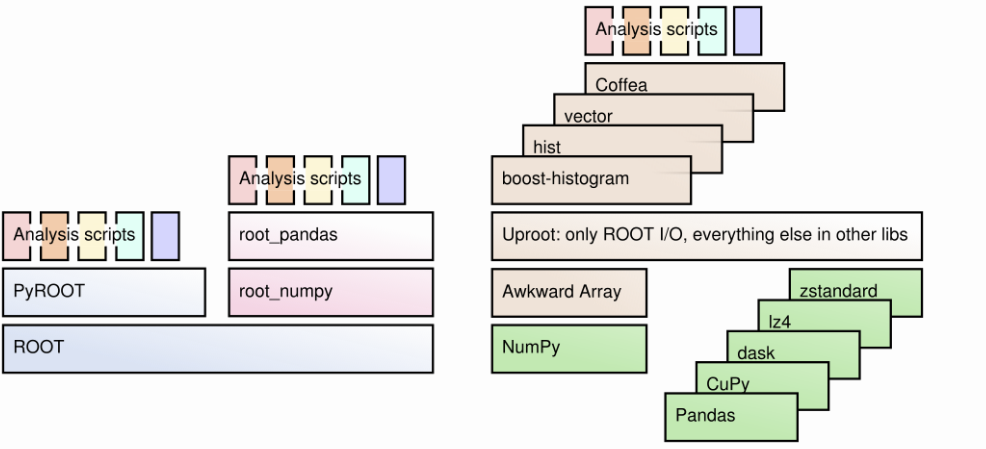

In [ ]:
!pip install awkward
!pip install uproot==3.9

## importing required libraries

In [ ]:
import scipy as sp
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as skm

In [ ]:
import gzip
from sklearn.decomposition import IncrementalPCA
import seaborn as sns

In [ ]:
import pkg_resources
import uproot
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import re
import awkward
 
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg as la
 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
 
from tqdm import tqdm
# import alive_progress
import time
seed = 666
np.random.seed(seed)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

In [ ]:
from math import sqrt

In [ ]:
np.random.seed(777)

### print_full(x) 
it put here and its job is to print whole a data frame

In [ ]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Features of input data
Based on the priore knoledge, and also with looking at the correlation matrix of the features of raw data, these features are selected.

In [ ]:
colmns = ['hit_tpc', 'hit_plane', 'no_hits', 'hit_wire', 'hit_peakT']

## Printing out the data from files
Changing the working directory to nues files path directory. "sigdir" represented nue files which inserted before.

In [ ]:
os.chdir(sigdir)
os.getcwd()

Calling all nue files where placed in a folder with glob.glob.

In [ ]:
allFiles_mu = os.listdir()
allFiles_mu = glob.glob('./*.root')

allFiles_mu.sort()
allFiles_mu

In [ ]:
# nue_400 contains some deferent tree files!!!
#allFiles_mu.remove('./nue_400.root')

## ROOT files
Root files use TTree to store ascii files. nue files are simolation of neutrino events(shortbase line) with keword 'icaana' and for branch is 'anatree;1'. By using Uproot 3.9, the files exxtracted as build-in Awkward array and then converted to pandas data frame for each nue files in the file.

In [ ]:
df = []
for file in allFiles_mu:
    tt = uproot.open(file)['icaana']['anatree;1']
    pf = tt.pandas.df((colmns))
    df.append(pf)

### Data Integration
The nue files(it is true about cosmic files) sould be combined. Each nue file contains from 100 entrys counted from 0 to 99. Therefore, it is required another index to identifiable entrys. It is done by putting the file names.

In [ ]:
df_con = pd.concat([df[i] for i in range(19)],ignore_index=False, keys=allFiles_mu)

In [ ]:
df_con

### Labeling
From Machine learning aspect, our problem is the binary classification. So we have to determine the target, here is nue files. For unsupervised learning, tagging is not required.

In [ ]:
tag = 'ev'
labl = 1
df_con['label'] = labl
df_con['tagg'] = tag

df_con

## Data Cleaning
we worked with Pandas. Hence, for cleaning and sanitaizing data from NA and NAN, .dropna() has been exploited.

In [ ]:
df_con = df_con.dropna()
print(df_con.info())

# Data reduction
Based on geometry of LAr TPC, the first induction of TPC has higher resolution i.e it has lower systematic uncertainity/noise in comparison with other area of TPC. In this notebook, the selected input data is provided by data beloning to collection and tpc 0 (hit_plane = 2, hit_tpc = 0)  and induction 2 and tpc 1 (hit_plane = 1, hit_tpc = 1).

In [ ]:
df_intpc0 = df_con.loc[df_con['hit_tpc'] == 0]
df_intpc1 = df_con.loc[df_con['hit_tpc'] == 1]

To combine these two area, it should be minded the mirroring effect in result of location of the anode and the cathod coils

In [ ]:
rep0 =df_intpc0.hit_peakT - 865
rep1 =-df_intpc1.hit_peakT + 5505

In [ ]:
df_intpc0.iloc[:, 4] = rep0
df_intpc1.iloc[:, 4] = rep1

In [ ]:
df_in0_2 = df_intpc0.loc[df_intpc0['hit_plane'] == 2]
df_in1_1 = df_intpc1.loc[df_intpc1['hit_plane'] == 1]

In [ ]:
df_in0_2

In [ ]:
df_in1_1

### Cosmic Files
The procedure is the same as it has been furbished for the nue files.

In [ ]:
os.chdir(backdir)
os.getcwd()

In [ ]:
FLocosmic = os.listdir()
FLocosmic = glob.glob('./*.root')

FLocosmic.sort()
FLocosmic

In [ ]:
dfc = []
for file in FLocosmic:
    ctt = uproot.open(file)['icaana']['anatree;1']
    cpf = ctt.pandas.df((colmns))
    dfc.append(cpf)

In [ ]:
dfc_con = pd.concat([dfc[i] for i in range(37)],ignore_index=False, keys=FLocosmic)

In [ ]:
lbl = 0
dfc_con['label'] = lbl

In [ ]:
tagi = 'cos'
dfc_con['tagg'] = tagi

In [ ]:
dfc_intpc0 = dfc_con.loc[dfc_con['hit_tpc'] == 0]
dfc_intpc1 = dfc_con.loc[dfc_con['hit_tpc'] == 1]

In [ ]:
repc0 =dfc_intpc0.hit_peakT - 865
repc1 =-dfc_intpc1.hit_peakT + 5505

In [ ]:
dfc_intpc0.iloc[:, 4] = repc0
dfc_intpc1.iloc[:, 4] = repc1

In [ ]:
dfc_in0_2 = dfc_intpc0.loc[dfc_intpc0['hit_plane'] == 2]
dfc_in1_1 = dfc_intpc1.loc[dfc_intpc1['hit_plane'] == 1]

In [ ]:
dfc_in1_1

In [ ]:
data = pd.concat([df_in0_2, df_in1_1, dfc_in0_2, dfc_in1_1])

##Scatter plots of data

###Scatter plots of nue - mix tpc

In [ ]:
for i in range(19):

  for j in range(100):
    plt.figure(figsize=(11,16))
    plt.title(allFiles_mu[i]+', entry: '+str(j), fontsize=18)
    plt.xlabel('hit_wire', fontsize=14)
    plt.ylabel('hit_peaktime', fontsize=14)
    pdf = df[i].iloc[df[i].index.get_level_values('entry') == j]
    p1 = pdf['hit_plane'] ==1
    ii = pdf['hit_plane'] ==2
    zo = pdf['hit_tpc'] ==0
    un = pdf['hit_tpc'] ==1
    #plt.scatter(pdf['hit_wire'],pdf['hit_peakT'], color = "white", marker = ".")
    plt.scatter(pdf['hit_wire'].loc[ii&zo],pdf['hit_peakT'].loc[ii&zo]-865, color = 'black')
    #plt.scatter(pdf['hit_wire'].loc[p1&zo],pdf['hit_peakT'].loc[p1&zo], color = 'red')
    plt.scatter(pdf['hit_wire'].loc[p1&un],pdf['hit_peakT'].loc[p1&un]*(-1)+5505, color = 'red')
    #lt.scatter(pdf['hit_wire'].loc[p1&un],pdf['hit_peakT'].loc[p1&un], color = 'green')
    ll = ['plane=2, tpc=0','plane=1, tpc=1']
    plt.legend(ll, loc="upper left", title="Classes")
    plt.show()

In [ ]:
plt.figure(figsize=(11,16))
plt.title('nue_all', fontsize=18)
plt.xlabel('hit_wire', fontsize=14)
plt.ylabel('hit_peaktime', fontsize=14)
for i in range(19):
  for j in range(250):
    pdf = df[i].iloc[df[i].index.get_level_values('entry') == j]
    p1 = pdf['hit_plane'] ==1
    ii = pdf['hit_plane'] ==2
    zo = pdf['hit_tpc'] ==0
    un = pdf['hit_tpc'] ==1
    plt.scatter(pdf['hit_wire'],pdf['hit_peakT'], color = "black", marker = ".")
    
    
    plt.scatter(pdf['hit_wire'].loc[ii&zo],pdf['hit_peakT'].loc[ii&zo]-865, color = 'red')
    plt.scatter(pdf['hit_wire'].loc[p1&un],-pdf['hit_peakT'].loc[p1&un]+5505, color = 'blue')

    ll = ['glob', 'plane=2, tpc=0','plane=1, tpc=1']
    plt.legend(ll, loc="lower right", title="Classes")
    plt.grid('on')

In [ ]:
for i in range(37):

  for j in range(250):
    plt.figure(figsize=(11,16))
    plt.title(FLocosmic[i]+', entry: '+str(j), fontsize=18)
    plt.xlabel('hit_wire', fontsize=14)
    plt.ylabel('hit_peaktime', fontsize=14)
    pdf = df[i].iloc[df[i].index.get_level_values('entry') == j]
    p1 = pdf['hit_plane'] ==1
    ii = pdf['hit_plane'] ==2
    zo = pdf['hit_tpc'] ==0
    un = pdf['hit_tpc'] ==1
    #plt.scatter(pdf['hit_wire'],pdf['hit_peakT'], color = "white", marker = ".")
    plt.scatter(pdf['hit_wire'].loc[ii&zo],pdf['hit_peakT'].loc[ii&zo]-865, color = 'green')
    #plt.scatter(pdf['hit_wire'].loc[p1&zo],pdf['hit_peakT'].loc[p1&zo], color = 'red')
    plt.scatter(pdf['hit_wire'].loc[p1&un],pdf['hit_peakT'].loc[p1&un]*(-1)+5505, color = 'blue')
    #lt.scatter(pdf['hit_wire'].loc[p1&un],pdf['hit_peakT'].loc[p1&un], color = 'green')
    ll = ['plane=2, tpc=0','plane=1, tpc=1']
    plt.legend(ll, loc="upper left", title="Classes")
    plt.show()

In [ ]:
plt.figure(figsize=(11,16))
plt.title('nues', fontsize=18)
plt.xlabel('hit_wire', fontsize=14)
plt.ylabel('hit_peaktime', fontsize=14)
for i in range(37):
  for j in range(250):
    pdf = df[i].iloc[df[i].index.get_level_values('entry') == j]
    p1 = pdf['hit_plane'] ==1
    ii = pdf['hit_plane'] ==2
    zo = pdf['hit_tpc'] ==0
    un = pdf['hit_tpc'] ==1
    #plt.scatter(pdf['hit_wire'],pdf['hit_peakT'], color = "black", marker = ".")
    
    #plt.scatter(pdf['hit_wire'].loc[p1&zo],pdf['hit_peakT'].loc[p1&zo]-865, color = 'red')
    #plt.scatter(pdf['hit_wire'].loc[p1&un],-pdf['hit_peakT'].loc[p1&un]+5505, color = 'green')
    plt.scatter(pdf['hit_wire'].loc[ii&zo],pdf['hit_peakT'].loc[ii&zo]-865, color = 'blue')
    plt.scatter(pdf['hit_wire'].loc[p1&un],-pdf['hit_peakT'].loc[p1&un]+5505, color = 'green')
    ll = ['plane=2, tpc=0','plane=1, tpc=1']
    plt.legend(ll, loc="lower right", title="Classes")
    plt.grid('on')

In [ ]:
datal = data.drop(['tagg', 'hit_tpc',	'hit_plane'], axis=1)
datal

# Traning the Data

## Data segmentation
For traning the data, usually the data split out to two subsets. It is done by train_test_split of Scikit-learn package.

In [ ]:
X = datal.drop(labels=['label'], axis = 1)

In [ ]:
Y = datal['label']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 76)

In [ ]:
X_train

### Receiver Operating Characteristic - ROC Curve Analysis
To evaluate the model(Random Forest), it is important to find true positive, false positive, true negative and false negative. By extracting them, it is easy to talk about the model as it means that concepts like selectivity, sensitivity, precision, miss rate and prevalence threshold and false omission rate are compromised.

In [ ]:
# funciton for ROC analysis
class ROC_Analysis():
    
    def __init__(self, name, true_labels, predictions, fpr_th=[0.01, 0.02, 0.05, 0.1, 0.2], model=None):
        
        self.name = name
        self.true_labels = true_labels
        self.predictions = predictions
        self.fpr_th = fpr_th
        
        self.fpr = None
        self.tpr = None
        self.thresholds = None
        self.AUC_score = None
        
        self.model = model
        
        
    def Compute_ROC_Curve(self):
        
        self.fpr, self.tpr, self.thresholds = roc_curve(self.true_labels, self.predictions)
        self.AUC_score = roc_auc_score(self.true_labels, self.predictions)
        
        
    def Find_Closest_Parameters(self):
        
        s = len(self.fpr_th)
        closest_fpr, closest_tpr, indexes = np.zeros(s), np.zeros(s), np.zeros(s, dtype=int)

        for ii in range(s):       
            indexes[ii] = np.searchsorted(self.fpr, self.fpr_th[ii])
        
        closest_fpr = self.fpr[indexes]
        closest_tpr = self.tpr[indexes]
        closest_th  = self.thresholds[indexes]
        
        return (closest_fpr, closest_tpr, closest_th)
    
        
    def Plot_ROC_Curve(self, axes=None):
        
        if self.AUC_score == None: self.Compute_ROC_Curve()
        
        if axes == None: fig, axes = plt.subplots(figsize=(7,6))
        axes.plot(self.fpr, self.tpr, color="blue", label=self.name+"_ROC")
        axes.plot([0, 1], [0, 1], color="darkred", linestyle='--', label="Random Guess")
        
        cl_fpr, cl_tpr, cl_th = self.Find_Closest_Parameters()
        axes.scatter(cl_fpr, cl_tpr, color="violet", label="Relevant pts, with thr. values")
        for ii in range(len(self.fpr_th)): 
            plt.annotate('%.3f' % cl_th[ii], (cl_fpr[ii], cl_tpr[ii]), 
                         xytext=(cl_fpr[ii]+0.03,cl_tpr[ii]-0.02),fontsize=11)
        
        txt_roc_auc = "roc_auc = %.3f" % self.AUC_score
        props = dict(boxstyle="round", facecolor="gold", alpha=0.5)
        axes.text(0.6, 0.4, txt_roc_auc, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)

        axes.set_xlabel("False Positive")
        axes.set_ylabel("True Positive")
        axes.set_title("ROC Curve of the " + self.name)
        axes.grid()
        axes.legend()
        
    
    def Display_Results(self):
        
        if self.AUC_score == None: self.Compute_ROC_Curve()        
        cl_fpr, cl_tpr, cl_th = self.Find_Closest_Parameters()
        
        inf_df = pd.DataFrame(np.vstack((np.array(self.fpr_th), cl_fpr, cl_tpr, cl_th)).round(4))
        inf_df.index = ['values', 'False Positive','True Positive','threshold']
        inf_df.columns = ['']*5
        
        return inf_df
            

## Searching for the best RF
The Grid search here has been reconciled. The most accordant RF would be a forest contains trees with min_samples_leaf = 1 and min_sample_split = 10 and the population of the forest would be 42 trees. It is necessary to mention that machine has been taghth in subentry level i.e the data has been comfronted disregarding the physical events.

In [ ]:
def RFF(bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators):
       
    return RandomForestClassifier( bootstrap=bootstrap, max_features=max_features, 
               min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
               n_estimators=n_estimators)


In [ ]:
pararafo = {'bootstrap': [True, False],'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1],  'min_samples_split': [10 ],
             'n_estimators': [37,47]}

In [ ]:
pararafo

In [ ]:
bulding_forest_start=time.time()
best_RF = {}
 
counter = 1
for params in tqdm(list(ParameterGrid(pararafo))):
    rf = RFF(**params)
    rf.fit(X_train, Y_train)
    pred = rf.predict_proba(X_test)[:, 1]
    best_RF['RF_'+str(counter)] = ROC_Analysis(name='RF_'+str(counter),  true_labels=Y_test, predictions=pred, model=rf)
    counter+=1
bulding_forest_end=time.time()

In [ ]:
t1 = bulding_forest_end - bulding_forest_start
print('wall time of building RFs: ', t1, 'sec')
print('wall time of building RFs: ', t1/60, 'min')

In [ ]:
def RF_Best_Model(analysis_objects, verbose=False):
    
    fig, ax = plt.subplots(2, 1, figsize=(15,22 ))
    
    # Setup comparison plot
    ax[0].plot([0, 1], [0, 1], color="green", linestyle='-.', label="Random Guess")
    ax[0].set_xlabel("False Positive")
    ax[0].set_ylabel("True Positive")
    ax[0].set_title("ROC Curves")
    
    best_model = None
    max_auc = 0
    auc_values = []
        
    for key in analysis_objects:
        analysis_objects[key].Compute_ROC_Curve()
        ax[0].plot(analysis_objects[key].fpr, analysis_objects[key].tpr)
        roc_auc = analysis_objects[key].AUC_score
        auc_values.append(roc_auc)
        if roc_auc > max_auc:
            best_model = analysis_objects[key]
            max_auc = roc_auc
        
        if verbose:
            print(key, "ROC AUC = ", roc_auc)
            
    
    # Setup best model plot
    best_model.Plot_ROC_Curve(axes=ax[1])
 
    hist_ax = fig.add_axes([0.22, 0.23, 0.1, 0.13])
    hist_ax.hist(auc_values, bins=len(analysis_objects))
    hist_ax.set_yticks([])
 
    return best_model

In [ ]:
rf.predict_proba(X_test) 
print(best_RF)
print(pred)

In [ ]:
print('random forest accuracy is ',rf.predict(X_test))

In [ ]:
from  sklearn.metrics import mean_squared_error

In [ ]:
# mse = mean_squared_error(actual, predicted)
predicted = rf.predict(X_test)
mse = mean_squared_error(Y_test, predicted)
rmse = math.sqrt(mse)
print('root mean square error for Random Forest',100*max(0,rmse)) 
print('accuracy of random forest',rf.score(X_test,Y_test))

In [ ]:
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [ ]:
test_scores = []
test_yhat = rf.predict(X_test)
test_acc = accuracy_score(Y_test, test_yhat)
test_scores.append(test_acc)
# summarize progress
print('test: %.3f' % (test_acc))

In [ ]:
best_randomforest = RF_Best_Model(best_RF, verbose=True)

In [ ]:
best_randomforest.model

## Results
True positive rate and false positive rate and also threshhold for the best RF have been driven. The results are significant that the model is eligible for the problem; discrimination of neutrinos versus background. 

In [ ]:
best_randomforest.Display_Results()

### Score of the best model

In [ ]:
Y_pred_test = rf.predict(X_test)
accuracy_score(Y_test, Y_pred_test)

In [ ]:
target_names = ['cos', 'nu']
print(classification_report(Y_test, Y_pred_test, target_names=target_names))

## Confusion Matrix

In [ ]:
con_mat = confusion_matrix(Y_test, Y_pred_test)
print(con_mat)

In [ ]:
con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(con_mat, annot=True, annot_kws={'size':16}, cmap='plasma', linewidths=0.2)
class_names = ['cos', 'nu']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for RF')
plt.show()

In [ ]:
from math import *

In [ ]:
TN = 932407; FP = 1662; FN = 8150; TP = 151769




In [ ]:
TN = 932407; FP = 1662; FN = 8150; TP = 151769
print('true negative(TN):=>', TN , '||','false positive(FP) :=>', FP)
print('================================================================')
print('false negative(FN):=>', FN ,' ||','true positive(TP) :=>', TP)
print('----------------------------------------------------------------')
P = FN + TP; N = TN + FP
print('P =>', P, 'N =>', N)
print('----------------------------------------------------------------')
TPR = TP/P; FNR = 1 - TPR
TNR = TN/N; FPR = 1 - TNR
PPV = TP/(TP+FP); FDR = 1 - PPV
NPV = TN/(TN+FN); FOR = 1 - NPV
TS = TP/(TP+FN+FP)
ACC = (TP+TN)/(P+N)
BA = (TPR+TNR)/2
print('\033[1m\033[91mSensitivity\033[1m\033[91m or \033[1m\033[91mtrue positive rate(TPR)\033[0m ==>', TPR)

print('\033[1m\033[91mMISS RATE or false negative rate(FNR)\033[0m ==>', FNR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mspecificity, selectivity or true negative rate(TNR)\033[0m ==>', TNR)

print('\033[1m\033[91mfall-out or false positive rate (FPR)\033[0m ==>', FPR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mprecision or positive predictive value(PPV)\033[0m ==>', PPV)

print('\033[1m\033[91mfalse discovery rate (FDR)\033[0m ==>', FDR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mnegative predictive value(NPV)\033[0m ==>', NPV)

print('\033[1m\033[91mfalse omission rate (FOR)\033[0m ==>', FOR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mthreat score(TS) or critical success index(CSI)\033[0m ==>', TS)

print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\\/\//\/\/\/\/\/\/\//\/\/\//\/\/\/\/\/\\//')

div = (sqrt(TPR*(-TNR+1)))+TNR-1
divder = TPR+TNR-1
PT = div/divder
print('\033[1m\033[91mprevalence threshold(PT)\033[0m ==>', PT)

# The outcomes

## Survey the model
In this stage, we studied the test data, findinghow the model could predict the data. The tast data has been already provided. Here Y_pred_test represented the model prediction and Y_test means true label of test data. The subtraction of these two labels shows if the model classified the input data correctly or not.

In [ ]:
er = Y_test - Y_pred_test
print(er)

### Appropriate Prediction Subset of Data 

In [ ]:
corrcases = er[er==0]
corrcases = corrcases.sort_index()

In [ ]:
corrcases_fr = corrcases.to_frame()

In [ ]:
corr_inx = corrcases_fr.index

In [ ]:
corr_df = data.loc[corr_inx]

In [ ]:
corr_nue = corr_df.loc[corr_df['label']==1]

In [ ]:
no_corrnue = len(corr_nue)

In [ ]:
corr_cosmic = corr_df.loc[corr_df['label']==0]
corr_cosmic

In [ ]:
no_corr_cosmic = len(corr_cosmic)

### nue files which have been predicted as cosmics

In [ ]:
ntcases = er[er==1]

In [ ]:
print('false negative =')
ntcases  = ntcases.sort_index()
print(ntcases)

In [ ]:
ntcases_df = ntcases.to_frame()
ntcases_df

In [ ]:
inx_falsenegative = ntcases_df.index

In [ ]:
falsenegative_df = data.loc[inx_falsenegative]
print('missclassified signals predicted as bacground:=:', falsenegative_df)
falsenegative_df

In [ ]:
print('Whole missclassified signals predicted as bacground:=:')
print_full(falsenegative_df)

In [ ]:
falsenegativedata = falsenegative_df.drop(['label', 'hit_tpc',	'hit_plane'], axis=1)

In [ ]:
https://colab.research.google.com/drive/1N4waqDsOYKu_Uf69-78rpK8CzYLQQuzt?usp=sharing

##wrong presiction over nue:

The plot below reports the percentage of wrong prediction of "part" of an event(entry). Our input nue data has 100*19 = 1900 entrys. As mentioned before, some of subentrys of each entry have been selected for tranning data. Hence, test data set aka unseen data containes some of full event.

In [ ]:
#fig = px.scatter(wrationue, x = 'entry', y = 'percentage of misclassified subentry', title= 'misclassified nue')
#fig.show()
https://colab.research.google.com/drive/1N4waqDsOYKu_Uf69-78rpK8CzYLQQuzt#scrollTo=oajj0rHiUbmc&line=1&uniqifier=1

### cosmic files that were predicted as nues

In [ ]:
pfcases = er[er==-1]

In [ ]:
print('false positive =')
pfcases  = pfcases.sort_index()
print(pfcases)

In [ ]:
positivetrue_df = pfcases.to_frame()
inx_positiveture = positivetrue_df.index

In [ ]:
positivetrue_df.index

In [ ]:
ptdataframe = data.loc[positivetrue_df.index]
print('missclassified bacground predicted as signals:=:', ptdataframe)
ptdataframe

In [ ]:
print('Whole missclassified bacgrounds predicted as signals:=:')
print_full(ptdataframe)

In [ ]:
df_ptdataframe = ptdataframe.drop(['label', 'hit_tpc',	'hit_plane'], axis=1)

In [ ]:
no_data = len(data.index.get_level_values('entry').unique().to_numpy()) + len(df_in0_2.index.get_level_values('entry').unique().to_numpy())
no_falsenegative = len(ntcases_df.index.get_level_values('entry').unique().to_numpy())
no_falspositve = len(positivetrue_df.index.get_level_values('entry').unique().to_numpy())
no_true = no_data - no_falsenegative

In [ ]:
falsenegative_df.info()

### The distribution of missclassified subentrys through entrys for cosmic files

In [ ]:
Fposdis = []
for i in range(len(ptdataframe)):
  xcv = ptdataframe.iloc[ptdataframe.index.get_level_values('entry') == i]
  lxcv = len(xcv)
  print(lxcv)
  Fposdis.append(lxcv)

#FNegdis_df.plot(figsize=(18,16), title='False Positive cases')

In [ ]:
Fposdis_df = pd.DataFrame(Fposdis)

In [ ]:
print_full(Fposdis_df)

In [ ]:
Fposdis_df_vi = Fposdis_df.T

###The distribution of missclassified subentrys through entrys for cosmic files

In [ ]:
FHNegdis_df = pd.DataFrame(FHNegdis)

In [ ]:
print_full(FHNegdis_df)

In [ ]:
https://colab.research.google.com/drive/1N4waqDsOYKu_Uf69-78rpK8CzYLQQuzt?usp=sharing

##WRONG PREDICTION COSMIC EVENTS

In [ ]:
fig = px.scatter(wrationue, x = 'entry', y = 'percentage of misclassified subentry', title= 'misclassified cosmic')
fig.show()

###Score of the model

Based on the results came out from the two graphs which indicated the percentage of wrong subentrys for each enty, one could extracte the score and other statistical detailes of the best RF

In [ ]:
#model.info in entry level
TN = 9261; FP = 231; FN = 738; TP = 1162
print('true negative(TN):=>', TN , '||','false positive(FP) :=>', FP)
print('================================================================')
print('false negative(FN):=>', FN ,' ||','true positive(TP) :=>', TP)
print('----------------------------------------------------------------')
P = FN + TP; N = TN + FP
print('P =>', P, 'N =>', N)
print('----------------------------------------------------------------')
TPR = TP/P; FNR = 1 - TPR
TNR = TN/N; FPR = 1 - TNR
PPV = TP/(TP+FP); FDR = 1 - PPV
NPV = TN/(TN+FN); FOR = 1 - NPV
TS = TP/(TP+FN+FP)
ACC = (TP+TN)/(P+N)
BA = (TPR+TNR)/2
print('\033[1m\033[91mSensitivity\033[1m\033[91m or \033[1m\033[91mtrue positive rate(TPR)\033[0m ==>', TPR)

print('\033[1m\033[91mMISS RATE or false negative rate(FNR)\033[0m ==>', FNR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mspecificity, selectivity or true negative rate(TNR)\033[0m ==>', TNR)

print('\033[1m\033[91mfall-out or false positive rate (FPR)\033[0m ==>', FPR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mprecision or positive predictive value(PPV)\033[0m ==>', PPV)

print('\033[1m\033[91mfalse discovery rate (FDR)\033[0m ==>', FDR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mnegative predictive value(NPV)\033[0m ==>', NPV)

print('\033[1m\033[91mfalse omission rate (FOR)\033[0m ==>', FOR)
print('_______________________________________________________________________________')
print('\033[1m\033[91mthreat score(TS) or critical success index(CSI)\033[0m ==>', TS)

print('/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\\/\//\/\/\/\/\/\/\//\/\/\//\/\/\/\/\/\\//')

div = (sqrt(TPR*(-TNR+1)))+TNR-1
divder = TPR+TNR-1
PT = div/divder
print('\033[1m\033[91mprevalence threshold(PT)\033[0m ==>', PT)
ACC = (TP+TN)/(P+N)
print('===================================================================================')
print('===================================================================================')
print('\033[1m\033[91mAccuracy of the model - entry level(ACC)\033[0m ==>', ACC)
print('===================================================================================')
print('===================================================================================')

## plot of correct and missclassified subentrys for an entry of nue files in the same canvas

In [ ]:
for i, j in zip(range(no_corrnue), range(no_falsenegative)):

  cordata = corr_nue.iloc[corr_nue.index.get_level_values('entry') == i]
  cp1 = cordata['hit_plane'] ==1
  cii = cordata['hit_plane'] ==2
  czo = cordata['hit_tpc'] ==0
  cun = cordata['hit_tpc'] ==1
  plt.title('MISSCLASSIFIED SIGNALS VERSUS CORRECT ONES', fontsize=18)
  plt.figure(figsize=(15,18))
  plt.xlabel('hit_wire', fontsize=18)
  plt.ylabel('hit_peaktime', fontsize=18)
  plt.scatter(cordata['hit_wire'],cordata['hit_peakT'], color = 'black', marker = '.')
  plt.scatter(cordata['hit_wire'].loc[cii&czo],cordata['hit_peakT'].loc[cii&czo], color = 'blue', marker = '.')
  plt.scatter(cordata['hit_wire'].loc[cp1&cun],cordata['hit_peakT'].loc[cp1&cun], color = 'green', marker = '+')
  indata = falsenegative_df.iloc[falsenegative_df.index.get_level_values('entry') == j]
  p1 = indata['hit_plane'] ==1 
  ii = indata['hit_plane'] ==2
  zo = indata['hit_tpc'] ==0
  un = indata['hit_tpc'] ==1
  plt.scatter(indata['hit_wire'].loc[ii&zo],indata['hit_peakT'].loc[ii&zo], color = 'black', marker = '*')
  plt.scatter(indata['hit_wire'].loc[p1&un],indata['hit_peakT'].loc[p1&un], color = 'red', marker = '+')
  ll = [ 'corr_plane=2, corr_tpc=0','corr_plane=1, corr_tpc=1', 'miss_plane=2, miss_tpc=0','miss_plane=1, miss_tpc=1']
  plt.legend(ll, loc="upper left", title="Classes") 
plt.show()

## plot of correct and missclassified subentrys for an entry of cosmic filesin the same canvas

In [ ]:
for i, j in zip(range(no_corr_cosmic), range(no_falspositve)):

  cordata = corr_cosmic.iloc[corr_cosmic.index.get_level_values('entry') == i]
  cp1 = cordata['hit_plane'] ==1
  cii = cordata['hit_plane'] ==2
  czo = cordata['hit_tpc'] ==0
  cun = cordata['hit_tpc'] ==1
  plt.title('MISSCLASSIFIED COSMICS VERSUS CORRECT ONES', fontsize=18)
  plt.figure(figsize=(15,18))
  plt.xlabel('hit_wire', fontsize=18)
  plt.ylabel('hit_peaktime', fontsize=18)
  plt.scatter(cordata['hit_wire'].loc[cii&czo],cordata['hit_peakT'].loc[cii&czo], color = 'green', marker = '.')
  plt.scatter(cordata['hit_wire'].loc[cp1&cun],cordata['hit_peakT'].loc[cp1&cun], color = 'blue', marker = '.')

  indata = ptdataframe.iloc[ptdataframe.index.get_level_values('entry') == j]
  p1 = indata['hit_plane'] ==1 
  ii = indata['hit_plane'] ==2
  zo = indata['hit_tpc'] ==0
  un = indata['hit_tpc'] ==1
  plt.scatter(indata['hit_wire'].loc[ii&zo],indata['hit_peakT'].loc[ii&zo], color = 'black', marker = '*')
  plt.scatter(indata['hit_wire'].loc[p1&un],indata['hit_peakT'].loc[p1&un], color = 'red', marker = '*')
  ll = [ 'corr_plane=2, corr_tpc=0','cos_plane=1, cos_tpc=1', 'miss_plane=2, miss_tpc=0','miss_plane=1, miss_tpc=1']
  plt.legend(ll, loc="upper left", title="Classes") 


plt.show()

In [ ]:
print('\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/')

#OUTCOMES

Based on results, the best RF model recorded the better efficiency to classify nue and cosmic for subentry level. The reason behind that refers to this subject that the samples or training data are single hit. Despite of that, the model turned over data from Collection (hit_plane = 2, hit_tpc = 0) granted the best performance, while the algorithm for induction 2 can predict the lower amount of single hits and also event. This might refer to this fact that Collection of ICARUS T600 has the highest resolution.
In all of cases, TNR is significantly more than TPR which tells us that the algorithm can recognize cosmic rays. It is also predictable as the size of cosmic 10 times higher than nue.
Consequently the performance of the model (specially TPR) increased when the input data came from collection with tpc = 0 in both entry and subentry level. Although the percentage of wrong predicted entry 

#Further down the road



*   Data with overlapped cosmic and neutrino hits
*   Application to real data with lower signal-to-noise ratio
*   Using real data with the current RF model and tuning the parameters of the model to increase the accurac

As mentioned before, the input data was true or simulated data. Therefore they are pretty clean without formidable noise. The next study could be including the reconstructed data with lower signal to noise ratio. For stepping on t his real life data, it is required to revision and reassessment of input data. The other features could be added to them like the deposited energy of the hits. Also the model might be eligible (with some manipulations) for  screening different types of neutrons.


